# UE Side Implementation-Downlink Time/Frame Synchronization using PSS in 5G Networks

Downlink time/frame synchronization using Primary Synchronization Signal (PSS) in 5G networks is a vital procedure for ensuring precise timing alignment between the base station (gNB) and user equipment (UE). Here's a more accurate breakdown:

1. **Purpose of Synchronization**: Synchronization is crucial for coordinating transmission and reception in wireless networks. In the downlink direction, precise synchronization ensures that UEs can correctly receive and decode the transmitted signals from the base station.
2. **Primary Synchronization Signal (PSS)**: PSS is a specific signal transmitted periodically by the base station. It consists of unique sequences known as primary synchronization sequences, which convey critical information such as cell identity and timing.
3. **UE Synchronization Process**: When a UE attempts to connect to a 5G network, it scans for nearby cells and detects PSS signals. By decoding the PSS, the UE identifies the cell's identity and estimates the timing offset between its internal clock and the base station's clock.
4. **Frame Synchronization**: Alongside time synchronization, frame synchronization ensures that the UE accurately identifies the boundaries of radio frames transmitted by the base station. This synchronization is essential for proper reception and processing of control and data information within each frame.
5. **Accurate Resource Allocation**: Precise time/frame synchronization enables efficient resource allocation by the base station. Aligned UEs allow optimal utilization of available resources, enhancing system capacity and throughput.
6. **Benefits and Impact**: Accurate downlink synchronization using PSS enhances overall network performance by improving reception quality, facilitating seamless handovers, and enabling efficient resource management. It ensures robust connectivity and enhances the user experience in 5G networks.

In summary, downlink time/frame synchronization using PSS is critical for ensuring reliable and efficient communication in 5G networks, providing precise timing alignment between base stations and user devices for seamless operation and optimal performance.


## 3.2 Import Libraries

### 3.2 Import Some Basic Python Libraries

In [1]:

# from IPython.display import display, HTML
# display(HTML("<style>.container { width:90% !important; }</style>"))

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# %matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation

import numpy as np
import adi


### 3.2 Import 5G Libraries

In [2]:

from toolkit5G.SequenceGeneration import PSS, SSS, DMRS
from toolkit5G.PhysicalChannels   import PBCH, PBCHDecoder
from toolkit5G.ResourceMapping    import SSB_Grid, ResourceMapperSSB
from toolkit5G.OFDM               import OFDMModulator, OFDMDemodulator
from toolkit5G.MIMOProcessing     import AnalogBeamforming, ReceiveCombining
from toolkit5G.ReceiverAlgorithms import PSSDetection, SSSDetection, ChannelEstimationAndEqualization, DMRSParameterDetection
from toolkit5G.Configurations     import TimeFrequency5GParameters, GenerateValidSSBParameters


## 3.2 Emulation Parameters

In [3]:
# System Parameters
center_frequency    = 1e9     # Carrier frequency for signal transmission

# OFDM Parameters
Bandwidth           = 5*10**6 # bandwidth
fftSize             = 1024    # FFT-size for OFDM
subcarrier_spacing  = 15000   # Subcarrier spacing
numOFDMSymbols      = 14      # Number of OFDM symbols considered for emulation | 1 slot
sample_rate         = fftSize*subcarrier_spacing # sample rate required by OFDM and DAC/ADC of SDR

# Pulse Shaping
numSamplesPerSymbol = 1


# number of samples returned per call to rx()
buffer_size         = int(fftSize*1.2*numSamplesPerSymbol*numOFDMSymbols)


## 3.2 SDR-Setup Configurations

In [4]:

# SDR setup
sdr             = adi.Pluto("ip:192.168.2.1")       # Create object of SDR setup object and configure the IP of SDR connect to the system
sdr.sample_rate = int(sample_rate)                  # Sets the sample rate for the ADC/DAC of the SDR.

# Config Rx
sdr.rx_lo                   = int(center_frequency) # Sets the receiver local oscillator frequency. 
# For Pluto SDR, rx_lo can take a value between 325 MHz to 3.8 GHz.
sdr.rx_rf_bandwidth         = int(60*10**6)         # Set the bandwidth (in Hz) of the reception filter
# For Pluto SDR, tx_rf_bandwidth should be between 200 kHz and 56 MHz.
sdr.rx_buffer_size          = int(buffer_size)      # Number of samples to read and load into SDR buffer.
# The upper limit on the size of this buffer is defined by the DRAM size.

sdr.gain_control_mode_chan0 = 'manual'              # Defines the mode of receiver AGC.
# # AGC modes: 
#     # 1. "manual"
#     # 2. "slow_attack"
#     # 3. "fast_attack"
# The receive gain on the Pluto has a range from 0 to 74.5 dB.

sdr.rx_hardwaregain_chan0   = 40.0 # dB, increase to increase the receive gain, but be careful not to saturate the ADC
# Sets the amplification gain (dB) provided by the low noise amplifier (LNA). 
# Relevant only when `gain_control_mode_chan0` is "manual".


## 3.2 Reception: SDR RF Receiver

In [5]:

# Clear buffer just to be safe
for i in range (0, 10):
    raw_data = sdr.rx()

# Receive samples
rx_samples = sdr.rx()

# # Stop transmitting
# sdr.tx_destroy_buffer()


## 3.2 Time Frequency Configurations

In [6]:
## This class fetches valid set of 5G parameters for the system configurations
nSymbolFrame= int(140*subcarrier_spacing/15000)
## This class fetches valid set of 5G parameters for the system configurations 
tfParams    = TimeFrequency5GParameters(Bandwidth, subcarrier_spacing)
tfParams(nSymbolFrame, typeCP = "normal")
nRB         = tfParams.numRBs        # SSB Grid size (Number of RBs considered for SSB transition)
Neff        = tfParams.Neff        # Number of resource blocks for Resource Grid ( exclude gaurd band | offsets : BWP)
Nfft        = 512                 # FFT-size for OFDM
lengthCP    = tfParams.lengthCP    # CP length

## 3.2 Time Synchronization: Based on PSS Correlation

**(rasterOffset, PSS-ID) (362, 0)
**(rasterOffset, PSS-ID) (362, 1)
**(rasterOffset, PSS-ID) (362, 2)


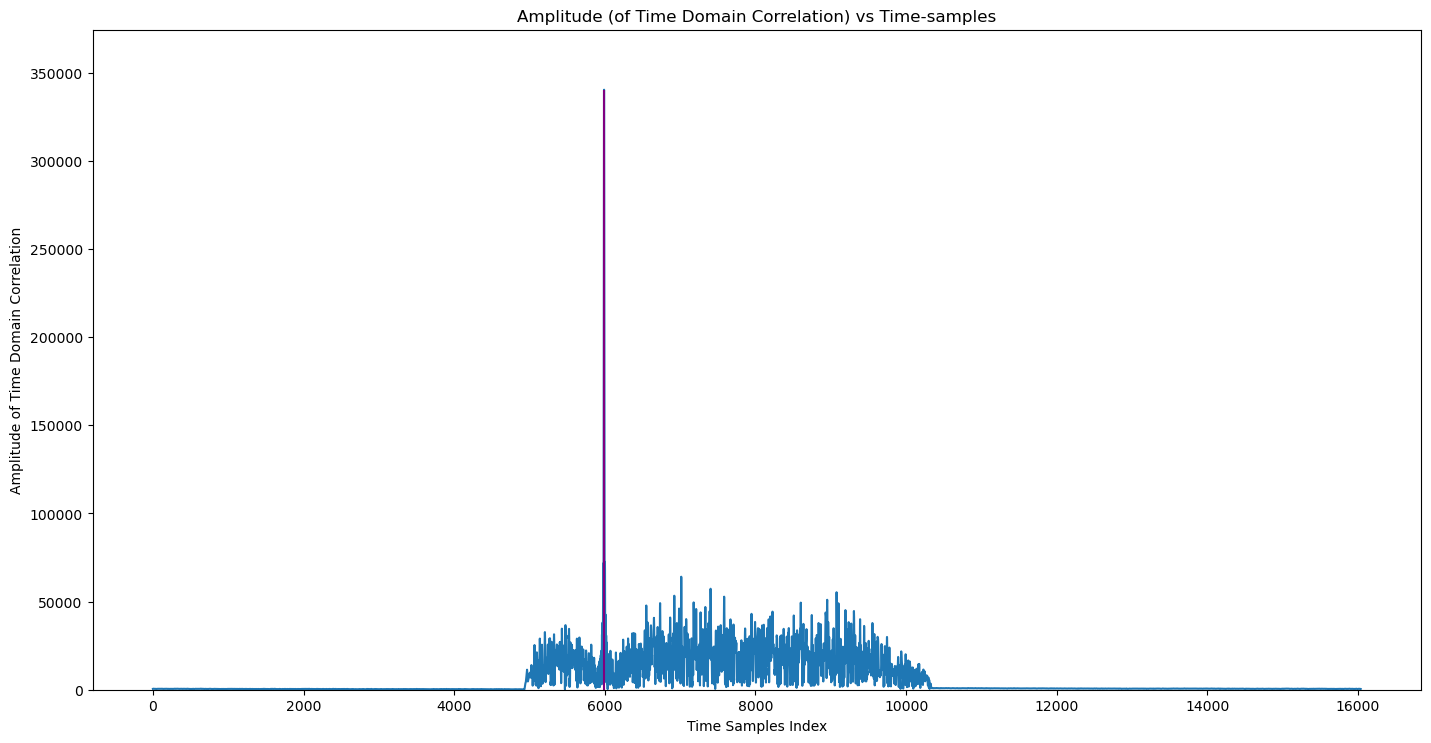

In [7]:
## PSS Detection: Based on time domain PSS Correlation
startingSubcarrierIndices = 0
pssDetection   = PSSDetection("largestPeak")
ssboffset      = int((fftSize-Neff)/2+startingSubcarrierIndices)
pssPeakIndices, pssCorrelation, rN_ID2, freqOffset = pssDetection(rx_samples, fftSize, lengthCP = lengthCP[1], 
                                                                  nID2=None, freqOffset = ssboffset)

## PSS Detection Plot
#################################################################
scaleFig = 1.75
fig, ax  = plt.subplots(figsize=(30/scaleFig, 15/scaleFig))

# single line
ax.plot(pssCorrelation)
ax.vlines(x = pssPeakIndices, ymin = 0*pssCorrelation[pssPeakIndices],
           ymax = pssCorrelation[pssPeakIndices], colors = 'purple')
ax.set_ylim([0,np.max(pssCorrelation)*1.1])
ax.set_xlabel("Time Samples Index")
ax.set_ylabel("Amplitude of Time Domain Correlation")
ax.set_title("Amplitude (of Time Domain Correlation) vs Time-samples")
plt.show()
#________________________________________________________________

## 3.2 Frame Synchronization: Visualization

``Note``: The following snippet of code only works with interactive maplotlib.

1. ![](caution.jpg) **Please ensure that you have intractive matplotlib installed on your system.**
2. **uncomment the ``%matplotlib widget`` in first code block for the following section of code to work**

In [8]:
correlation    = np.zeros((3, pssCorrelation.size), dtype = np.float32)
r              = rx_samples[i:i+fftSize]
correlation[0] = np.abs(np.correlate(rx_samples, np.squeeze(pssDetection.pssRTime[0]), mode='valid'))
correlation[1] = np.abs(np.correlate(rx_samples, np.squeeze(pssDetection.pssRTime[1]), mode='valid'))
correlation[2] = np.abs(np.correlate(rx_samples, np.squeeze(pssDetection.pssRTime[2]), mode='valid'))

# function that draws each frame of the animation
def animate(i):

    ax[0].clear()
    ax[0].grid()
    ax[0].plot(correlation[0,0:scale*(i+1)], color='k', label = "Correlation With PSS with $n_{ID}^{2}=0$")
    ax[0].legend()
    ax[0].set_xlim([0,pssCorrelation.size])
    ax[0].set_ylim([0,np.max(pssCorrelation)*1.1])

    ax[1].clear()
    ax[1].grid()
    ax[1].plot(correlation[1,0:scale*(i+1)], color='g', label = "Correlation With PSS with $n_{ID}^{2}=1$")
    ax[1].legend()
    ax[1].set_xlim([0,pssCorrelation.size])
    ax[1].set_ylim([0,np.max(pssCorrelation)*1.1])

    ax[2].clear()
    ax[2].grid()
    ax[2].plot(correlation[2,0:scale*(i+1)], color='b', label = "Correlation With PSS with $n_{ID}^{2}=2$")
    ax[2].legend()
    ax[2].set_xlim([0,pssCorrelation.size])
    ax[2].set_ylim([0,np.max(pssCorrelation)*1.1])
    
    ax[3].clear()
    ax[3].grid()
    ax[3].plot(np.real(rx_samples[0:scale*(i+1)]), color='r', label = "real part of received signal")
    ax[3].plot(np.imag(rx_samples[0:scale*(i+1)]), color='y', label = "imaginary part of received signal")
    ax[3].legend()
    ax[3].set_xlim([0,pssCorrelation.size])
    ax[3].set_ylim([minX,maxY])

minX = np.min([np.real(rx_samples).min(), np.imag(rx_samples).min()])
maxY = np.max([np.real(rx_samples).max(), np.imag(rx_samples).max()])
# create the figure and axes objects
scaleFig = 1.75
fig, ax  = plt.subplots(4,1,figsize=(30/scaleFig, 20/scaleFig))
fig.suptitle('Spectrum of the Received Signal', fontsize=10)

scale = 100
#####################
# run the animation
#####################
# frames= 20 means 20 times the animation function is called.
# interval=500 means 500 milliseconds between each frame.
# repeat=False means that after all the frames are drawn, the animation will not repeat.
# Note: plt.show() line is always called after the FuncAnimation line.


anim = animation.FuncAnimation(fig, animate, frames=int(np.floor((correlation.size-1)/scale)), interval=1, repeat=False, blit=True)
# saving to mp4 using ffmpeg writer
plt.show()

# anim.save("Overall.gif", fps = 10)

# writervideo = animation.FFMpegWriter(fps=60) 
# anim.save('Overall.mp4', writer=writervideo)

![Overall-3.2](Overall.gif)

## 3.2 Saving Running frames

``Note``: The following snippet of code only works with interactive maplotlib.

1. ![caution-3.2](caution.jpg) **Please ensure that you have intractive matplotlib installed on your system.**
2. **uncomment the ``%matplotlib widget`` in first code block for the following section of code to work**

In [9]:

# function that draws each frame of the animation
def animate(i):
    if scale*i+fftSize < rx_samples.size:
        ax1[3].clear()
        ax1[3].grid()
        ax1[3].plot(np.arange(scale*i,(scale*i+fftSize)), np.real(rx_samples[scale*i:(scale*i+fftSize)]), color='r', label = "real part of received signal")
        ax1[3].plot(np.arange(scale*i,(scale*i+fftSize)), np.imag(rx_samples[scale*i:(scale*i+fftSize)]), color='y', label = "imaginary part of received signal")
        ax1[3].legend()
        ax1[3].set_xlim([scale*i, scale*i+fftSize])
        ax1[3].set_ylim([minX,maxY])

# create the fig1ure and axes objects
scalefig1 = 1.75
fig1, ax1  = plt.subplots(4,1,figsize=(30/scalefig1, 20/scalefig1))
fig1.suptitle('Spectrum of the Received Signal', fontsize=10)

minX = np.min([np.real(pssDetection.pssRTime[0]).min(), np.imag(pssDetection.pssRTime[0]).min()])
maxY = np.max([np.real(pssDetection.pssRTime[0]).max(), np.imag(pssDetection.pssRTime[0]).max()])

ax1[0].plot(np.real(pssDetection.pssRTime[0]), color='k', label = "real part of Time domain PSS with $n_{ID}^{2}=0$")
ax1[0].plot(np.imag(pssDetection.pssRTime[0]), color='r', label = "imaginary part of Time domain PSS with $n_{ID}^{2}=0$")
ax1[0].legend()
ax1[0].set_xlim([0,pssDetection.pssRTime[2].size])
ax1[0].set_ylim([minX,maxY])

minX = np.min([np.real(pssDetection.pssRTime[1]).min(), np.imag(pssDetection.pssRTime[1]).min()])
maxY = np.max([np.real(pssDetection.pssRTime[1]).max(), np.imag(pssDetection.pssRTime[1]).max()])

ax1[1].plot(np.real(pssDetection.pssRTime[1]), color='k', label = "real part of Time domain PSS with $n_{ID}^{2}=1$")
ax1[1].plot(np.imag(pssDetection.pssRTime[1]), color='r', label = "imaginary part of Time domain PSS with $n_{ID}^{2}=1$")
ax1[1].legend()
ax1[1].set_xlim([0,pssDetection.pssRTime[2].size])
ax1[1].set_ylim([minX,maxY])

minX = np.min([np.real(pssDetection.pssRTime[2]).min(), np.imag(pssDetection.pssRTime[2]).min()])
max1Y = np.max([np.real(pssDetection.pssRTime[2]).max(), np.imag(pssDetection.pssRTime[2]).max()])
ax1[2].plot(np.real(pssDetection.pssRTime[2]), color='k', label = "real part of Time domain PSS with $n_{ID}^{2}=2$")
ax1[2].plot(np.imag(pssDetection.pssRTime[2]), color='r', label = "imaginary part of Time domain PSS with $n_{ID}^{2}=2$")
ax1[2].legend()
ax1[2].set_xlim([0,pssDetection.pssRTime[2].size])
ax1[2].set_ylim([minX,maxY])

# fig1.clear()
minX = np.min([np.real(rx_samples).min(), np.imag(rx_samples).min()])
maxY = np.max([np.real(rx_samples).max(), np.imag(rx_samples).max()])

scale = 100
#####################
# run the animation
#####################
# frames= 20 means 20 times the animation function is called.
# interval=500 means 500 milliseconds between each frame.
# repeat=False means that after all the frames are drawn, the animation will not repeat.
# Note: plt.show() line is always called after the FuncAnimation line.


anim1 = animation.FuncAnimation(fig1, animate, frames=int(np.floor((rx_samples.size-1)/scale)-1), interval=1, repeat=False, blit=True)
# saving to mp4 using ffmpeg writer
plt.show()

# anim1.save("Overall_frame.gif", fps = 10)

# writervideo = animation.FFMpegWriter(fps=60) 
# anim1.save('Overall_frame.mp4', writer=writervideo)

![Overall_frame-3.2](Overall_frame.gif)